# Create LMDB dataset

References:
* http://docs.h5py.org/en/latest/quick.html
* http://docs.h5py.org/en/latest/high/file.html
* http://docs.h5py.org/en/latest/high/dataset.html?highlight=create_dataset
* http://docs.h5py.org/en/latest/high/group.html?highlight=get
* http://stackoverflow.com/questions/11753418/check-if-node-exists-in-h5py
* http://stackoverflow.com/questions/16213525/updating-h5py-datasets
* http://stackoverflow.com/questions/25655588/incremental-writes-to-hdf5-with-h5py
* http://stackoverflow.com/questions/22998248/how-to-resize-an-hdf5-array-with-h5py/26208582

In [1]:
# Counter to keep track of LMDB index
idx_lmdb = 0

In [2]:
import lmdb
import numpy as np
import scipy.misc
import random
import matplotlib.pyplot as plt
import sys

folder_dataset = "../Track1_Wheel/"
LMDB_PATH = '../DatasetLMDB'

### Read dataset directory

In [3]:
# Lists to hold image filename and label
xs = []
ys = []

with open(folder_dataset + "data.txt") as f:
    for line in f:
        # Image path
        xs.append(folder_dataset + line.split()[0])        
        # Steering wheel label
        ys.append(np.float32(line.split()[1]))

num_images = len(xs)
print("Number of images: %d" % num_images)

# Use zip to create a list with images/labels
c = list(zip(xs, ys))
#random.shuffle(c)
xs, ys = list(zip(*c))

Number of images: 1660


### Load images into memory(as ndarray)

In [4]:
list_imgs = []
for imPath in xs:
    image = scipy.misc.imread(imPath, mode="RGB")
    list_imgs.append(image)


# Just print to debug
print(list_imgs[0].shape)

(256, 256, 3)


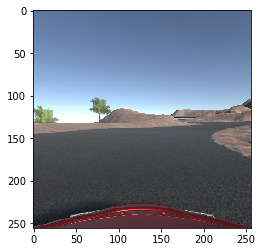

Wheel angle: 0.12854


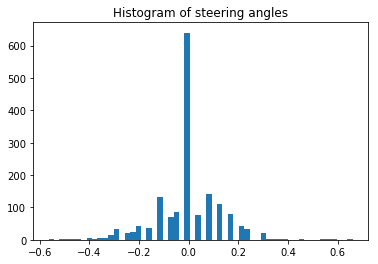

In [5]:
rand_index = random.randint(0,len(list_imgs)-1)
plt.imshow(list_imgs[rand_index])
plt.show()
print('Wheel angle:', ys[rand_index])
plt.hist(ys,bins='auto')
plt.title("Histogram of steering angles")
plt.show()

### Calculate sizes

In [6]:
# get size in bytes of lists
size_bytes_images = list_imgs[0].nbytes * len(list_imgs)
size_bytes_labels = ys[0].nbytes * len(ys)
total_size = size_bytes_images + size_bytes_labels
print('Total size(bytes): %d' % (size_bytes_images+size_bytes_labels))
print('Number of elements:', len(ys))
print('Type of images: ', type(list_imgs), 'of', list_imgs[0].dtype)
print('Type of labels: ', type(ys), 'of', ys[0].dtype)

# Convert shape tupple into string separated with '_
shape_img = list_imgs[0].shape
shape_str = '_'.join([str(dim) for dim in shape_img])
print('Image shape',shape_img)
print('Image size in bytes',list_imgs[0].nbytes)

Total size(bytes): 326375920
Number of elements: 1660
Type of images:  <class 'list'> of uint8
Type of labels:  <class 'tuple'> of float32
Image shape (256, 256, 3)
Image size in bytes 196608


## Create LMDB dataset

In [7]:
# Open LMDB file
# You can append more information up to the total size.
env = lmdb.open(LMDB_PATH, map_size=total_size*15)

## Add information on LMDB

In [8]:
# Get a write lmdb transaction, lmdb store stuff with a key,value(in bytes) format
with env.begin(write=True) as txn:
    # Iterate on batch    
    for (tup_element) in list(zip(list_imgs, ys)):
        img,steer = tup_element        
        str_id = 'label_{:08}'.format(idx_lmdb)   
        # Encode shape information on key
        img_id = ('img_{:08}_' + shape_str).format(idx_lmdb)           
        # The current type of steer is np.float32 and img ndarray of float32
        txn.put(bytes(str_id.encode('ascii')),steer.tobytes())                
        txn.put(bytes(img_id.encode('ascii')),img.tobytes())                        
        idx_lmdb += 1

### Select some element and display

In [9]:
lst_labels_read = []
lst_imgs_read = []
env = lmdb.open(LMDB_PATH, readonly=True)
with env.begin() as txn:
    cursor = txn.cursor()
    for key, value in cursor:                
        key_str = key.decode('ascii')
        #print(key_str)
        if 'label' in key_str:            
            lst_labels_read.append(np.float32(np.asscalar(np.frombuffer(value, dtype=np.float32, count=1))))
        else:            
            # Get shape information from key name
            info_key = key_str.split('_')
            # Get image shape [2:None] means from index 2 to the end
            shape_img = tuple(map(lambda x:int(x) ,info_key[2:None]))            
            # Convert to float32
            lst_imgs_read.append(np.frombuffer(value, dtype=np.uint8).reshape(shape_img).astype(np.float32))  

Dataset size: 1660


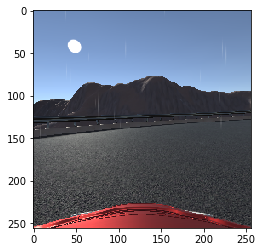

Wheel angle: 0.661099


In [10]:
print('Dataset size:', len(lst_imgs_read))
rand_index = random.randint(0,len(lst_imgs_read)-1)
plt.imshow(lst_imgs_read[rand_index].astype(np.uint8))
plt.show()
print('Wheel angle:', lst_labels_read[rand_index])

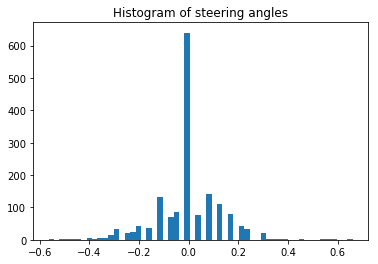

In [11]:
plt.hist(lst_labels_read,bins='auto')
plt.title("Histogram of steering angles")
plt.show()